# Experiment #1 - Baseline Model vs. Baseline ML Models

## Overview

The purpose of this experiment is to establish a baseline for a domain-driven model and to compare it to more sophisticated machine learning models using baseline features. Without collaboration with stakeholders or additional predictors such as customer tenure, lifetime value, historical response rate, etc., our baseline model will simply follow our intuited rule:

> Include the customer if they responded positively to the previous marketing campaign. If there were not enough respondents to use up the entire budget then randomly sample the training set for additional instances to ensure that the maximum number of customers are included.

To estimate the performance of machine learning models, we will train the following models with three different hyperparameter configurations, selecting the best configuration and averaging the scores of the best models:

* Naive Bayes
* Decision tree
* Logististic regression
* Neural network
* SVM

Scores will be based on how well a classifier can prioritize 6.6% of the population since that is all our budget allows for when deploying a model to classify all 100,000 customers.

In [1]:
%load_ext autoreload
%autoreload 2

from utils import code

In [2]:
import pandas as pd
import numpy as np
import scikitplot as skplt

# Model evaluation
from sklearn.metrics import make_scorer, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict
from support.evaluation import plot_learning_curve, evaluate_model

# Support
from support.pipeline import get_pipeline, get_feature_names_for_pipeline
from support.model import Model, build_tuned_model
from support.datasets import get_data
from support.experiments import experiment_1, get_scorer
from support import parameters as params

# Algos
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

%matplotlib inline

## Data

In [3]:
X, y = get_data('../data/train.csv')
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,25,blue-collar,single,high.school,no,yes,no,cellular,jul,mon,619,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
1,40,admin.,married,high.school,no,no,no,telephone,jun,thu,97,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1
2,51,technician,married,university.degree,no,yes,no,cellular,aug,wed,512,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
3,37,blue-collar,married,high.school,unknown,yes,no,cellular,jul,tue,423,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
4,54,housemaid,married,university.degree,unknown,yes,no,cellular,aug,thu,297,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1


In [4]:
n_instances = len(X)
p_instances = y.sum() / len(y)
p_targeted = .066
n_targeted = int(n_instances*p_targeted)

print('Number of instances: {:,}'.format(n_instances))
print('Number of conversions {:,}'.format(y.sum()))
print('Conversion rate: {:.2f}%'.format(p_instances*100.))
print('6.6% of the population {:,}'.format(n_targeted))
print('Expected number of conversions targetting {:,} @ {:.2f}%: {:,}'.format(n_targeted, p_instances*100., int(p_instances * n_targeted)))

Number of instances: 32,950
Number of conversions 3,712
Conversion rate: 11.27%
6.6% of the population 2,174
Expected number of conversions targetting 2,174 @ 11.27%: 244


Create a validation set and train the model then score on the test set. The performance will be biased since we are using less training data.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=1)
n_targeted_test = int(len(X_test) * p_targeted)

## Baseline Model

As stated above, our baseline model is simply the rule "predict the customer will convert if they converted when contacted as part of the previous campaign". Whether the customer converted during the previous campaign is encoded in the attribute `poutcome` which can take on three values: success, failure, or nonexistent. We are assuming that 'nonexistent' means that the customer was not part of the previous campaign (see the exploratory notebook - Exploratory Questions).

In [20]:
# Setup costs and benefits
avg_revenue = params.AVG_REVENUE
avg_cost = params.AVG_COST

In [21]:
# Get all of the instances where the previous campaign was a success
X_test_success = X_test[X_test.poutcome == 'success']

# Calcuate how many more instances we need
n_rest = n_targeted_test - len(X_test_success)

# Randomly choose from the remaining instances
rest = X_test[~(X_test.index.isin(X_test_success.index))].sample(n=n_rest, random_state=1)

In [22]:
# Combine the targeted and random groups
baseline_targets = pd.concat([X_test_success, rest], axis=0)
baseline_ys = y_test.loc[baseline_targets.index]
baseline_outcomes = baseline_ys.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)
assert(len(baseline_targets) == n_targeted_test)

In [23]:
# Create the random targets
random_targets = X_test.sample(n=n_targeted_test)
random_ys = y.loc[random_targets.index]
random_outcomes = random_ys.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)

In [24]:
# Compute profit
random_profit = sum(random_outcomes)
baseline_profit = sum(baseline_outcomes)

print('Number of customers targeted: {:,}/{:,}\n'.format(len(baseline_targets), len(X_test)))

print('Conversion rate under random policy: {:.1f}%'.format(random_ys.sum() / len(random_ys)*100.))
print('Expected profit under random policy: ${:,}\n'.format(random_profit))

print('Conversion rate under baseline policy: {:.1}%'.format(baseline_ys.sum() / len(baseline_ys)*100.))
print('Expected profit under baseline policy: ${:,}'.format(baseline_profit))
print('Lift over random policy: {:.1f} or ${:,}'.format(baseline_profit / random_profit, baseline_profit - random_profit))

Number of customers targeted: 434/6,590

Conversion rate under random policy: 10.14%
Expected profit under random policy: $44,180

Conversion rate under baseline policy: 40.55%
Expected profit under baseline policy: $187,136
Lift over random policy: 4.2 or $142,956


## ML Models

Optimize each model we're interested in evaluating then choose the best one and estimate financial impact.

In [5]:
scorer = get_scorer()

Apply feature computations

In [6]:
pipeline = experiment_1.get_pipeline()
ps = pipeline.fit_transform(X).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 32,950, Features: 61


Configure and run the different algos

In [7]:
results = []

In [8]:
# Naive Bayes
param_grid = [{
  'nb__alpha': [0, 0.01, 0.1, 1],
  'nb__fit_prior': [True, False]
}]

# We need to use the categorical pipeline since BernoulliNB only handles
# categorical features
nb_pipeline = experiment_1.get_categorical_pipeline()
result = evaluate_model(X, y, 'nb', BernoulliNB(), param_grid, scorer, nb_pipeline)
results.append(result)

==> Starting 5-fold cross validation for nb model, 32950 examples
==> Elapsed seconds: 5.583
Best nb model: BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=False)
Best nb score: 0.668


In [ ]:
# Decision tree
param_grid = [{
  'dt__criterion': ['gini', 'entropy'],
  'dt__max_depth': [1, 50, 100],
  'dt__min_samples_leaf': [5, 10]
}]

result = evaluate_model(X, y, 'dt', DecisionTreeClassifier(), param_grid, pipeline)
results.append(result)

In [ ]:
#  Logistic regression
param_grid = [{
  'lr__C': [.001, .01, 1.],
  'lr__penalty': ['l1', 'l2']
}]

result = evaluate_model(X, y, 'lr', LogisticRegression(), param_grid, pipeline)
results.append(result)

In [ ]:
# NN
param_grid = [{
  'nn__hidden_layer_sizes': [(10), (100), (200)],
#   'nn__activation': ['logistic', 'tanh', 'relu'],
#   'nn__solver': ['lbfgs']
}]

result = evaluate_model(X, y, 'nn', MLPClassifier(), param_grid, pipeline)
results.append(result)

In [ ]:
#  SVM
param_grid = [{
  'svm__C': [.001, .01, 1.],
  'svm__gamma': [.1, 1., 2.],
  'svm__kernel': ['rbf']
}]

result = evaluate_model(X, y, 'svm', SVC(), param_grid, pipeline)
results.append(result)

In [ ]:
pd.DataFrame.from_dict(list(map(lambda x: { 'model': x[1], 'mean': x[2], 'std': x[3] }, results)))[[
  'model', 'mean', 'std'
]].sort_values('mean', ascending=False).style.bar()

## Financial Impact of the Best Model

So now that we have evaluated models and estimated their generalization accuracy, we will select the best model and take a closer look at its performance and what we can expect in terms of profitability for targeting 6.6% of the population.

In [32]:
model_result = list(filter(lambda x: x[1] == 'nb', results))[0]
model = model_result[0]
model.model
print('Best model performance mean:', model_result[2])
print('Best model performance std:', model_result[3])

Best model performance mean: 0.668297066184034
Best model performance std: 0.006536914255911055


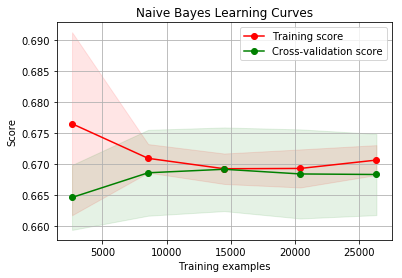

In [33]:
plot_learning_curve(model.model, 'Naive Bayes Learning Curves', model.pipeline.fit_transform(X), y, cv=5, scoring=scorer);

The model may be suffering from high bias - we could improve the performance - but we don't have to be concerned with variance (our model will generalize well).
Run 5-fold cross validation using the optimized model and print the metrics

In [34]:
preds = cross_val_predict(model.get_model_pipeline(), X, y, cv=5)

In [35]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76     29238
           1       0.20      0.70      0.31      3712

   micro avg       0.64      0.64      0.64     32950
   macro avg       0.57      0.67      0.53     32950
weighted avg       0.86      0.64      0.71     32950



While our model isn't very precise (we are correct in predicting a conversion 20% of the time, 80% of the time we get a false positive), it does a very good job (compared to random guessing) at finding customers that are likely to convert.

In [36]:
model.pipeline.fit(X_train)
model.model.fit(model.pipeline.transform(X_train), y_train)

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=False)

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


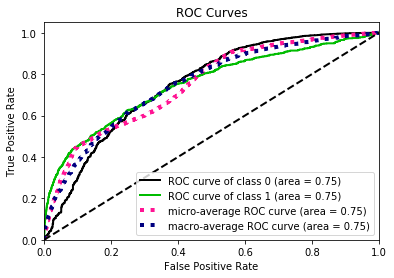

In [37]:
probs = model.model.predict_proba(model.pipeline.transform(X_test))
preds = model.model.predict(model.pipeline.transform(X_test))

_ = skplt.metrics.cumulative_gain_curve(y_test, probs);

If we wanted to reduce the number of false positives, we could choose a probability threshold that corresponds to a lower (FPR, TPR) point on the ROC curve but since our profit margin is so high (assuming that our cost and revenue estimatios are correct), then we can afford the misclassifications so long as the classifier does a good job of selecting customers who end up converting.

Evaluate financial performance

In [28]:
# Create a dataframe of probabilities and actual / predicted outcomes
probs_df = pd.DataFrame(np.hstack([probs, y_test.values.reshape(-1,1), preds.reshape(-1,1)]), columns=['p_no', 'p_yes', 'actual', 'predicted'])

# Sort customers by the probability that they will convert
model_targets = probs_df.sort_values('p_yes', ascending=False)

# Take the top 6.6%
model_targets = model_targets.head(n_targeted_test)

# Calculate financial outcomes
model_outcomes = model_targets.actual.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)

Model performance for top 6.6%

In [29]:
print(classification_report(model_targets.actual, model_targets.predicted))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       206
         1.0       0.53      1.00      0.69       228

   micro avg       0.53      0.53      0.53       434
   macro avg       0.26      0.50      0.34       434
weighted avg       0.28      0.53      0.36       434



/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
# Calculate profit
model_profit = sum(model_outcomes)

print('Number of customers targeted: {:,}/{:,}'.format(len(model_targets), len(X_test)))
print('Conversion rate of model policy: {:.2f}%'.format(model_targets.actual.sum() / len(model_outcomes)*100.))
print('Expected profit of model policy: ${:,}'.format(model_profit))
print('Lift over random: {:.1f} or ${:,}'.format(model_profit / random_profit, model_profit - random_profit))
print('Lift over baseline: {:.1f} or ${:,}'.format(model_profit / baseline_profit, model_profit - baseline_profit))

Number of customers targeted: 434/6,590
Conversion rate under baseline policy: 52.53%
Expected profit under model policy: $243,452
Lift over random: 5.5 or $199,272
Lift over baseline: 1.3 or $56,316


Save the model

In [11]:
model.save('../models/experiment-1-model.pkl')